In [227]:

import matplotlib.pyplot as plt
import yaml
with open('frozen_stats/stats', 'r') as f:
    data_full = yaml.load(f.read())

In [228]:
colors = [
'#c19277', #mpeg
'#62959c', #ours
'#9dad7f', #dds
'#d9dab0', #eaar
'#a98b98', #cloudseg
'#c1c0b9' # reducto
]

In [229]:

import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Ellipse

def filter(keywords):
    assert isinstance(keywords, list)
    temp = [i for i in data_full if all(keyword in i['video_name'] for keyword in keywords)]
    return temp[-1]

def filters(keywords):
    assert isinstance(keywords, list)
    temp = [i for i in data_full if all(keyword in i['video_name'] for keyword in keywords)]
    return temp

def transform(data_list):
    return [i['bw'] / i['gt_bw'] for i in data_list], [i['f1'] for i in data_list]

def savefig(filename, fig):
    import time
    timestr = time.strftime("%Y%m%d-%H%M%S")
    filename = f'{filename}_time_{timestr}.pdf'
    fig.savefig(filename, bbox_inches='tight')

def add_data(ax, data, color):

    # print(data[1])
    cov = np.cov(data[0], data[1])
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_) / math.sqrt(len(data[0]))
    
    print(np.mean(data[1]))

    ell = Ellipse(xy=(np.mean(data[0]), np.mean(data[1])),
            width=lambda_[0]*2,
            height=lambda_[1]*2,
            angle=np.rad2deg(np.arccos(v[0,0])),
            alpha=0.9)
    ell.set_edgecolor(color)
    ell.set_facecolor(color)
    ax.add_artist(ell)
    #plt.scatter(data[0], data[1], c = color)
    ax.scatter([np.mean(data[0])], [np.mean(data[1])], marker = 'o', color = 'black', s=10,zorder=3)
    return np.mean(data[0]).item(), np.mean(data[1]).item()


In [230]:
# add ground truth bandwidth for normalization purpose
for data in data_full:
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']

# set default parameters
plt.style.use('default')
plt.rcParams['font.size']=30
plt.rc('font', family='sans-serif')
plt.rcParams["font.weight"] = "medium"
plt.rcParams['pdf.fonttype'] = 42

0.7472340404987335
0.7777071356773376
0.8005468726158143
0.8803070306777954
0.6444799661636352
0.8068541526794434


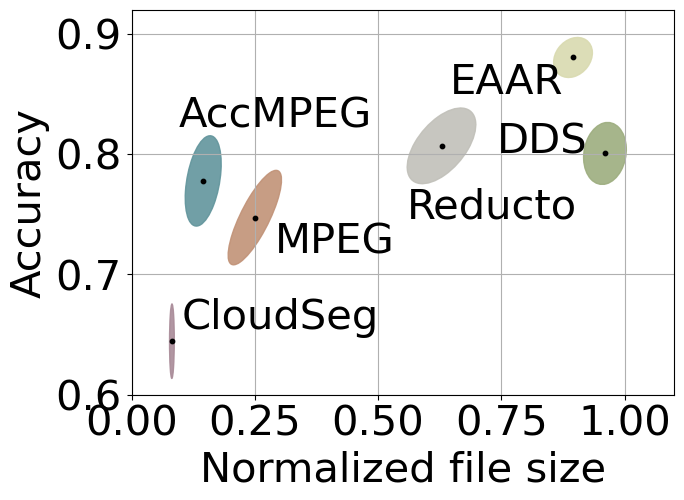

In [204]:

# plot dashcam

ids = [(i+1) for i in range(10)]
accs = [filter([f'dashcam/dashcam_{i}_', 'final_single', 'bound_0.3', 'conv_9']) for i in ids]
ddss = [filter([f'dashcam/dashcam_{i}_', 'dds']) for i in ids]
eaars = [filter([f'dashcam/dashcam_{i}_', 'eaar']) for i in ids]
cloudsegs = [filter([f'dashcam/dashcam_{i}_', 'cloudseg', '40']) for i in ids]
reductos = [filter([f'dashcam/dashcam_{i}_', 'reducto', '28']) for i in ids]
mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([f'dashcam/dashcam_{i}_qp_'])

    batch = [b for b in batch if b['f1'] < acc['f1']]
    batch = sorted(batch, key=lambda x: -x['bw'])
    mpegs.append(batch[0])

accs = transform(accs)
mpegs = transform(mpegs)
ddss = transform(ddss)
eaars = transform(eaars)
cloudsegs = transform(cloudsegs)
reductos = transform(reductos)



fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

x, y = add_data(ax, mpegs, colors[0])
ax.text(x+0.04, y-0.03, 'MPEG')
x, y = add_data(ax, accs, colors[1])
ax.text(x-0.05, y+0.045, 'AccMPEG')
x, y = add_data(ax, ddss, colors[2])
ax.text(x-0.22, y, 'DDS')
x, y = add_data(ax, eaars, colors[3])
ax.text(x-0.25, y-0.03, 'EAAR')
x, y = add_data(ax, cloudsegs, colors[4])
ax.text(x+0.02, y+0.01, 'CloudSeg')
x, y = add_data(ax, reductos, colors[5])
ax.text(x-0.07, y-0.06, 'Reducto')
ax.set_xlim(0, 1.1)
ax.set_ylim(0.6, 0.92)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

savefig('figs/detection_dashcam', fig)




0.7687479257583618
0.7980058073997498
0.6528869271278381
0.7999021649360657
0.4212186634540558
0.6127951383590698


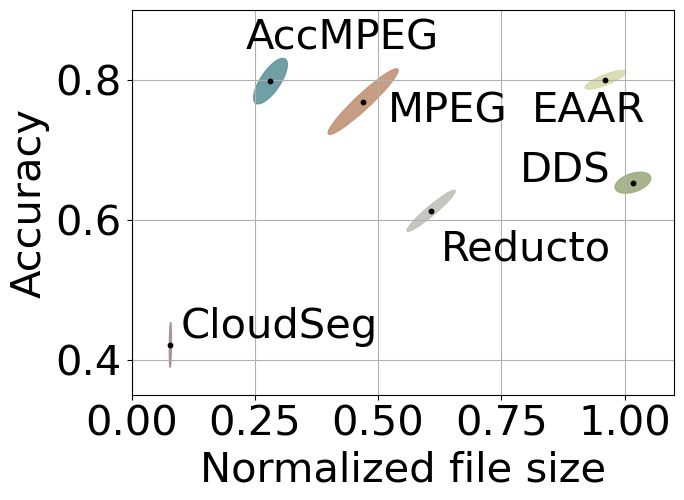

In [209]:

# plot drone

ids = [169, 170, 171, 172, 173]
accs = [filter([f'visdrone/videos/vis_{i}', 'final_single', 'bound_0.3', 'conv_9']) for i in ids]
ddss = [filter([f'visdrone/videos/vis_{i}', 'dds']) for i in ids]
eaars = [filter([f'visdrone/videos/vis_{i}', 'eaar']) for i in ids]
cloudsegs = [filter([f'visdrone/videos/vis_{i}', 'cloudseg', '40']) for i in ids]
reductos = [filter([f'visdrone/videos/vis_{i}', 'reducto', '28']) for i in ids]
mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([f'visdrone/videos/vis_{i}_qp'])

    batch = [b for b in batch if b['f1'] < acc['f1']]
    batch = sorted(batch, key=lambda x: -x['bw'])
    mpegs.append(batch[0])

accs = transform(accs)
mpegs = transform(mpegs)
ddss = transform(ddss)
eaars = transform(eaars)
cloudsegs = transform(cloudsegs)
reductos = transform(reductos)



fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

x, y = add_data(ax, mpegs, colors[0])
ax.text(x+0.05, y-0.03, 'MPEG')
x, y = add_data(ax, accs, colors[1])
ax.text(x-0.05, y+0.045, 'AccMPEG')
x, y = add_data(ax, ddss, colors[2])
ax.text(x-0.23, y, 'DDS')
x, y = add_data(ax, eaars, colors[3])
ax.text(x-0.15, y-0.06, 'EAAR')
x, y = add_data(ax, cloudsegs, colors[4])
ax.text(x+0.02, y+0.01, 'CloudSeg')
x, y = add_data(ax, reductos, colors[5])
ax.text(x+0.02, y-0.07, 'Reducto')

ax.set_xlim(0, 1.1)
ax.set_ylim(0.35, 0.9)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

savefig('figs/detection_vis', fig)




0.8483760714530945
0.7380643725395203
0.7980058073997498


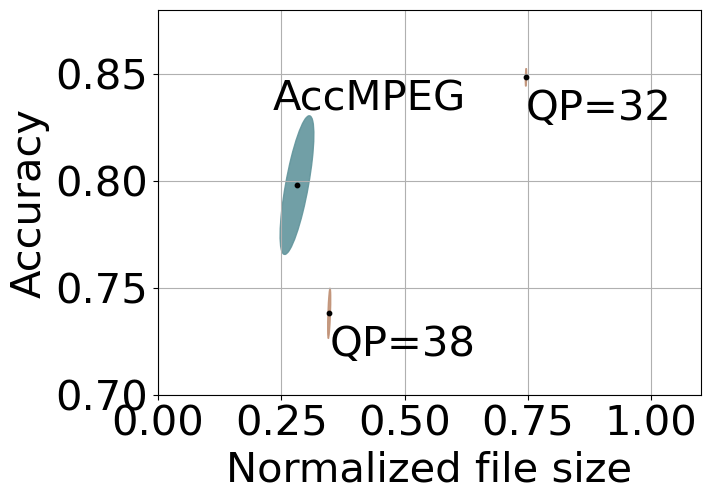

In [251]:

# plot dashcam for Fig18

ids = range(169, 174)
accs = [filter([f'visdrone/videos/vis_{i}', 'final_single', 'bound_0.3', 'conv_9']) for i in ids]
mpeg32 = [filter([f'visdrone/videos/vis_{i}_qp_32']) for i in ids]
mpeg42 = [filter([f'visdrone/videos/vis_{i}_qp_38']) for i in ids]

accs = transform(accs)
mpeg32 = transform(mpeg32)
mpeg42 = transform(mpeg42)



fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

x, y = add_data(ax, mpeg32, colors[0])
ax.text(x, y-0.02, 'QP=32')
x, y = add_data(ax, mpeg42, colors[0])
ax.text(x, y-0.02, 'QP=38')
x, y = add_data(ax, accs, colors[1])
ax.text(x-0.05, y+0.035, 'AccMPEG')
ax.set_xlim(0, 1.1)
ax.set_ylim(0.7, 0.88)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

savefig('figs/detection_qp', fig)




0.5861300468444824
0.6203420639038086
0.32340488880872725


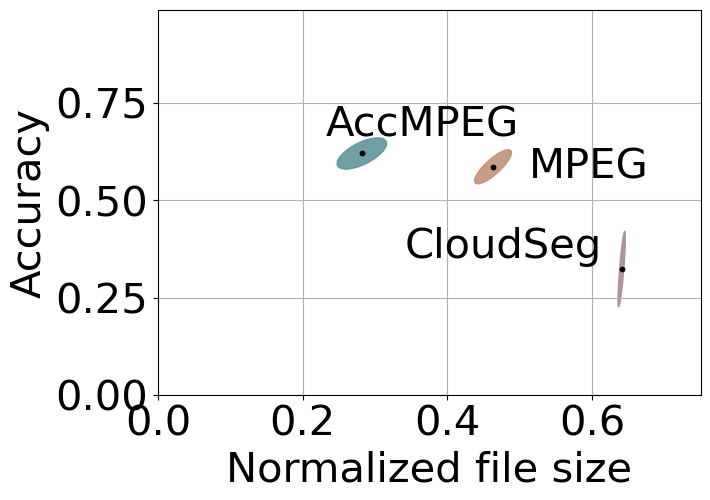

In [280]:

# plot segmentation drone


import matplotlib.pyplot as plt
import yaml
with open('frozen_stats/stats_segmentation', 'r') as f:
    data_full = yaml.load(f.read())
# add ground truth bandwidth for normalization purpose
for data in data_full:
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']
def transform(data_list):
    return [i['bw'] / i['gt_bw'] for i in data_list], [i['acc'] for i in data_list]

# plot drone

ids = [169, 170, 171, 172, 173]
accs = [filter([f'visdrone/videos/vis_{i}', 'final_single', 'bound_0.3', 'conv_9']) for i in ids]
mpegs = []
for i, acc in zip(ids, accs):
    batch = filters([f'visdrone/videos/vis_{i}_qp'])

    batch = [b for b in batch if b['acc'] < acc['acc']]
    batch = sorted(batch, key=lambda x: -x['bw'])
    mpegs.append(batch[0])
cloudsegs = [filter([f'visdrone/videos/vis_{i}', 'cloudseg', 'qp_25']) for i in ids]

accs = transform(accs)
mpegs = transform(mpegs)
cloudsegs = transform(cloudsegs)


fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()

x, y = add_data(ax, mpegs, colors[0])
ax.text(x+0.05, y-0.03, 'MPEG')
x, y = add_data(ax, accs, colors[1])
ax.text(x-0.05, y+0.045, 'AccMPEG')
x, y = add_data(ax, cloudsegs, colors[4])
ax.text(x-0.3, y+0.03, 'CloudSeg')
ax.set_xlim(0, 0.75)
ax.set_ylim(0, 0.99)
#ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Normalized file size')
ax.set_ylabel('Accuracy')

savefig('figs/segmentation_vis', fig)





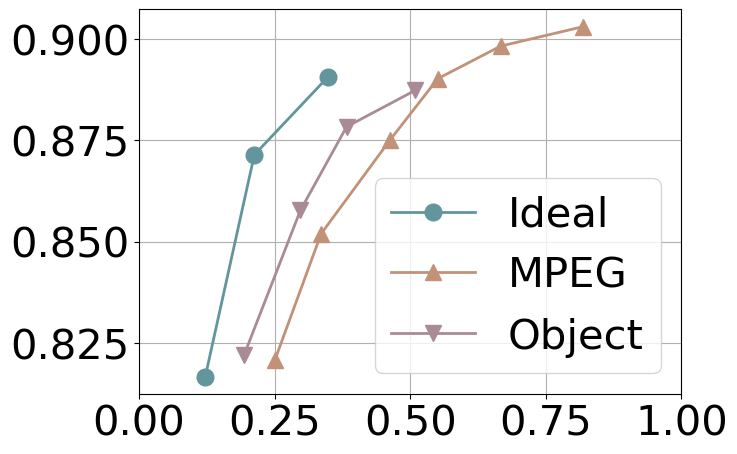

In [267]:
# plot measurement figure
with open('frozen_stats/stats_measurement_detection', 'r') as f:
    data_full = yaml.load(f.read())
# add ground truth bandwidth for normalization purpose
for data in data_full:
    data['gt_bw'] = filter([data['ground_truth_name']])['bw']
def transform(data_list):
    return np.mean([i['bw'] / i['gt_bw'] for i in data_list]), np.mean([i['f1'] for i in data_list])

# plot drone

ids = [169, 170, 171, 172, 173]

gt_delta32 = transform([filter([f'visdrone/videos/vis_{i}', 'gt_bbox', 'delta_32']) for i in ids])
gt_delta64 = transform([filter([f'visdrone/videos/vis_{i}', 'gt_bbox', 'delta_64']) for i in ids])
gt_delta128 = transform([filter([f'visdrone/videos/vis_{i}', 'gt_bbox', 'delta_128']) for i in ids])

qpvals = [ 25, 26, 27, 28, 30, 32]
qpdata = [transform([filter([f'visdrone/videos/vis_{i}_qp_{qp}']) for i in ids]) for qp in qpvals]


qpvals = [36, 32, 30, 28]
objdata = [transform([filter([f'visdrone/videos/vis_{i}', 'blackgen_dual', f'qp_{qp}']) for i in ids]) for qp in qpvals]

fig, ax = plt.subplots(figsize=(7, 5))
ax.grid()
ax.set_xlim((0, 1))
ax.plot([gt_delta32[0], gt_delta64[0], gt_delta128[0]], [gt_delta32[1], gt_delta64[1], gt_delta128[1]], c=colors[1], linewidth=2, markersize=12, marker='o', label='Ideal')

ax.plot([i[0] for i in qpdata], [i[1] for i in qpdata], c=colors[0], linewidth=2, markersize=12, marker='^', label='MPEG')
ax.plot([i[0] for i in objdata], [i[1] for i in objdata], c=colors[4], linewidth=2, markersize=12, marker='v', label='Object')
ax.legend()
savefig('figs/measurement_detection', fig)


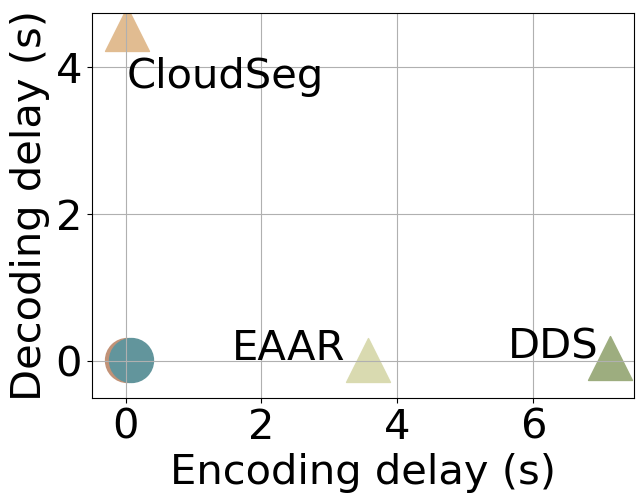

In [150]:
# plot ingestion delay
import re
pattern = re.compile('for ([0-9\.]*)')


with open('frozen_stats/blackgen.cpu', 'r') as f:
    cpu = [float(i) for i in pattern.findall(f.read())]
with open('frozen_stats/blackgen.gpu', 'r') as f:
    gpu = [float(i) for i in pattern.findall(f.read())]

mp4 = 1/55
mp5 = 1/35
webm = 1/14
cpu = np.mean(cpu) / 30
gpu = np.mean(gpu) / 30
inf_dnn = 3.55
inf_sr = 4.5

mpeg = [mp4, mp4]
acc = [mp4 + cpu, mp4]
dds = [mp4+mp4+inf_dnn+inf_dnn, mp4+mp4]
eaar = [mp4 + inf_dnn, mp4]
cloudseg = [mp4, mp4+inf_sr]
# reduc = [mp4, mp4]


fig, ax = plt.subplots(figsize=(7, 5))

def scat(name, c, deltax, deltay, text, marker):
    ax.scatter([name[0]], [name[1]], c=c, s=1000, marker=marker)
    ax.text(name[0]+deltax, name[1]+deltay, text)

scat(mpeg, colors[0], 0, 0, '', 'o')
scat(acc, colors[1], 0, 0, '', 'o')
scat(dds, colors[2], -1.5, 0, 'DDS', '^')
scat(eaar, colors[3], -2, 0, 'EAAR', '^')
scat(cloudseg, colors[4], 0, -0.8, 'CloudSeg', '^')
ax.set_xlim(left=-0.5)
ax.set_ylim(bottom=-0.5)
# ax.set_xlim(left=0)
# ax.set_ylim(bottom=0)
ax.set_xlabel('Encoding delay (s)')
ax.set_ylabel('Decoding delay (s)')
ax.grid()

savefig('figs/delay', fig)


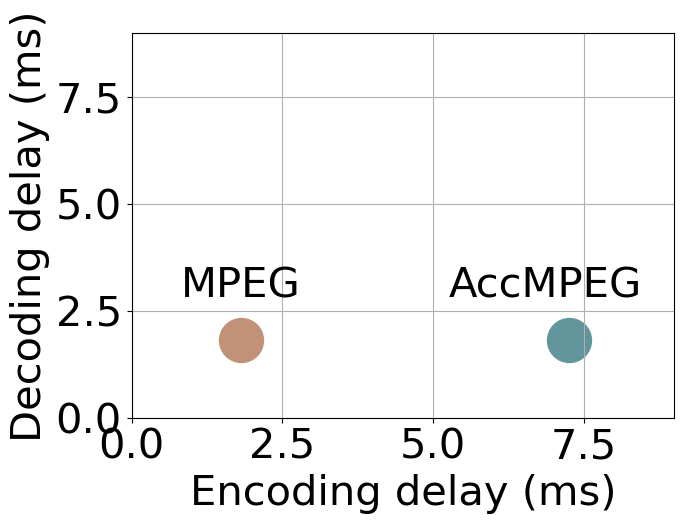

In [168]:

# plot ingestion delay
import re
pattern = re.compile('for ([0-9\.]*)')


with open('frozen_stats/blackgen.cpu', 'r') as f:
    cpu = [float(i) for i in pattern.findall(f.read())]
with open('frozen_stats/blackgen.gpu', 'r') as f:
    gpu = [float(i) for i in pattern.findall(f.read())]

mp4 = 1/55
mp5 = 1/35
webm = 1/14
cpu = np.mean(cpu) / 30
gpu = np.mean(gpu) / 30
inf_dnn = 3.55
inf_sr = 4.5

mpeg = [mp4, mp4]
acc = [mp4 + cpu, mp4]
dds = [mp4+mp4+inf_dnn+inf_dnn, mp4+mp4]
eaar = [mp4 + inf_dnn, mp4]
cloudseg = [mp4, mp4+inf_sr]
# reduc = [mp4, mp4]


fig, ax = plt.subplots(figsize=(7, 5))

def scat(name, c, deltax, deltay, text, marker):
    ax.scatter([100*name[0]], [100*name[1]], c=c, s=1000, marker=marker)
    ax.text(100*name[0]+deltax, 100*name[1]+deltay, text)

scat(mpeg, colors[0], -1, 1, 'MPEG', 'o')
scat(acc, colors[1], -2, 1, 'AccMPEG', 'o')
ax.set_xlim((0, 9))
ax.set_ylim((0, 9))
# ax.set_xlim(left=0)
# ax.set_ylim(bottom=0)
ax.set_xlabel('Encoding delay (ms)')
ax.set_ylabel('Decoding delay (ms)')
ax.grid()

savefig('figs/delay2', fig)
